In [6]:
using DICOM
using Interact, Plots

In [7]:
# This volume is comprised of 133 individual slices
run(`ls -C ../data/cxr/`)

LoadError: IOError: could not spawn `ls -C ../data/cxr/`: no such file or directory (ENOENT)

In [8]:
dcm_data = dcm_parse("../data/cxr/1-001.dcm")
keys(dcm_data)

KeySet for a Dict{Tuple{UInt16, UInt16}, Any} with 97 entries. Keys:
  (0x0040, 0x2016)
  (0x0012, 0x0063)
  (0x0028, 0x0303)
  (0x0010, 0x0010)
  (0x0018, 0x1111)
  (0x0008, 0x0030)
  (0x0040, 0xa123)
  (0x0018, 0x1140)
  (0x0002, 0x0016)
  (0x0020, 0x0052)
  (0x0028, 0x0100)
  (0x0013, 0x0010)
  (0x0002, 0x0001)
  (0x0020, 0x0037)
  (0x0008, 0x1090)
  (0x0018, 0x5100)
  (0x0010, 0x1010)
  (0x0018, 0x1160)
  (0x0002, 0x0012)
  (0x0040, 0xa124)
  (0x0002, 0x0002)
  (0x0040, 0x0244)
  (0x0013, 0x1010)
  (0x0040, 0x2017)
  (0x0028, 0x1052)
  ⋮

`img_data` is a (512, 512) matrix


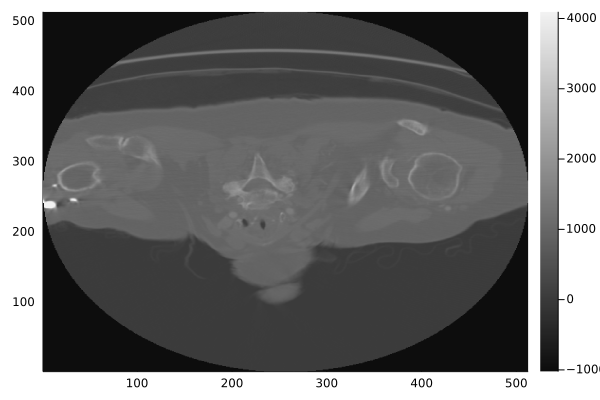

In [9]:
img_data = dcm_data[tag"PixelData"]
nx, ny = size(img_data)
println("`img_data` is a $((nx, ny)) matrix")
heatmap(img_data, c=:grays)

In [10]:
# Read multiple .dcm files
dcm_data_array = dcmdir_parse("../data/cxr/")
n_dcm = length(dcm_data_array)
print("There are $(n_dcm) DICOM files in the directory")

There are 133 DICOM files in the directory

In [35]:
using Interpolations

┌ Info: Precompiling Interpolations [a98d9a8b-a2ab-59e6-89dd-64a1c18fca59]
└ @ Base loading.jl:1423


In [87]:
firstCoord = dcm_data_array[n_dcm][tag"ImagePositionPatient"]
secondCoord = dcm_data_array[n_dcm - 1][tag"ImagePositionPatient"]
firstCoord .≈ secondCoord

gapAxis = findall( x -> x == 0, firstCoord .≈ secondCoord )[1]

3

In [96]:
# Load the slices into a single volume
volume = Array{Int16}(undef, (n_dcm, nx, ny))

gapCoords = Array{Float64}(undef,n_dcm)
z_spacing = Array{Float64}(undef,n_dcm-1)

# first slice of volume 
slice = dcm_data_array[end][tag"PixelData"][end:-1:1, :]
volume[1, :, :] = slice
gapCoords[1] = dcm_data_array[end][tag"ImagePositionPatient"][gapAxis] 

# Create the volume
for i in 2:n_dcm
    # A little slice reordering is necessary to get this looking right
    slice = dcm_data_array[end-i+1][tag"PixelData"][end:-1:1, :]
    volume[i, :, :] = slice

    # find z spacing
    gapCoords[i] = dcm_data_array[end-i+1][tag"ImagePositionPatient"][gapAxis] 
    z_spacing[i-1] = gapCoords[i] - gapCoords[i-1]

end

In [106]:
sum(.!(z_spacing[1] .≈ z_spacing))

0

In [91]:
gapCoords

133-element Vector{Float64}:
 -340.0
 -337.5
 -335.0
 -332.5
 -330.0
 -327.5
 -325.0
 -322.5
 -320.0
 -317.5
 -315.0
 -312.5
 -310.0
    ⋮
  -37.5
  -35.0
  -32.5
  -30.0
  -27.5
  -25.0
  -22.5
  -20.0
  -17.5
  -15.0
  -12.5
  -10.0

In [64]:
pxSpacing = dcm_data_array[1][tag"PixelSpacing"][1]

vox_space = minimum(gapCoords):pxSpacing:maximum(gapCoords) 

-340.0:0.703125:-10.234375

In [94]:
x_spacing, y_spacing = dcm_data_array[1][tag"PixelSpacing"]

2-element Vector{Float64}:
 0.703125
 0.703125

In [95]:
x_spacing

0.703125

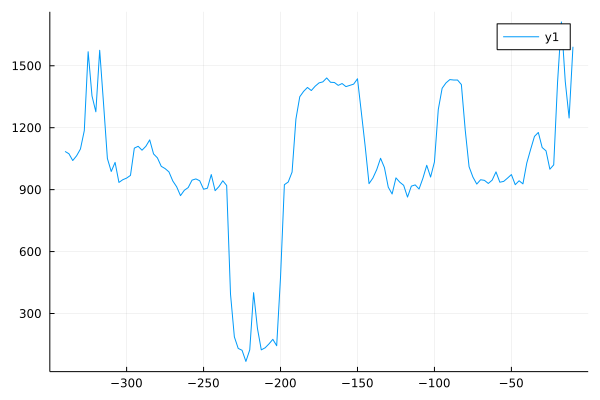

In [39]:
data_col = ct_volume[:, 250, 250]

plot(gapCoords, data_col)

In [40]:
interp_linear = LinearInterpolation(gapCoords, data_col)

133-element extrapolate(interpolate((::Vector{Float64},), ::Vector{Int16}, Gridded(Linear())), Throw()) with element type Float64:
 1085.0
 1074.0
 1041.0
 1064.0
 1097.0
 1186.0
 1568.0
 1354.0
 1277.0
 1575.0
 1317.0
 1051.0
  988.0
    ⋮
 1095.0
 1158.0
 1177.0
 1104.0
 1088.0
  999.0
 1020.0
 1421.0
 1712.0
 1424.0
 1247.0
 1592.0

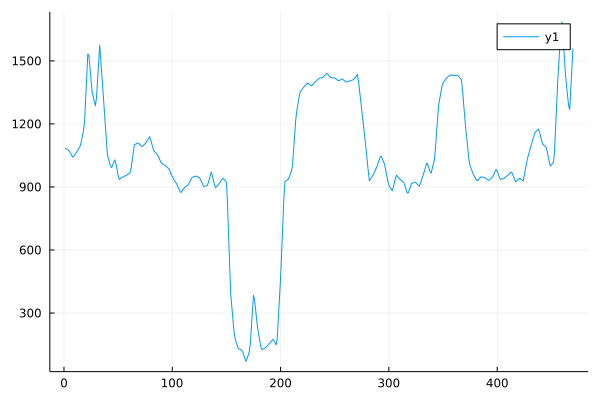

In [61]:
plot(interp_linear(vox_space))

In [68]:
ct_volLin = Array{Int16}(undef, (length(vox_space), nx, ny))

for x in 1:nx, y in 1:ny
    data_col = ct_volume[:, x, y]
    interpol = LinearInterpolation(gapCoords, data_col)
    newcol = interpol(vox_space)
    ct_volLin[:, x, y] = round.(newcol)
end

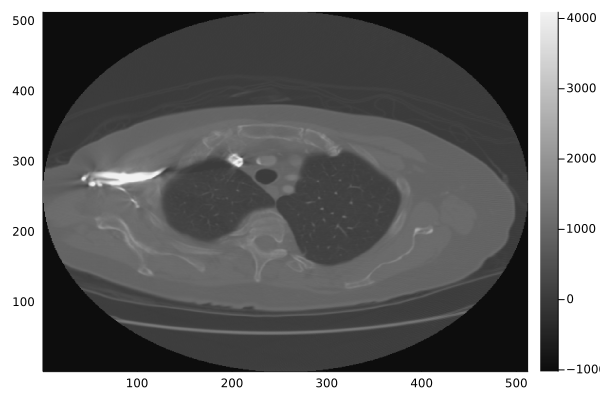

In [70]:
heatmap(ct_volLin[400,:,:], c=:grays)

In [12]:
# Plot the CT and move through the transverse plane
@manipulate for slice in 1:n_dcm
    heatmap(
        ct_volume[slice, :, :], 
        c=:grays, 
        clims=(minimum(ct_volume), maximum(ct_volume))
    )
end

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any["slice"], Dict{Symbol, Any}(:className => "interact ", :style => Dict{Any, Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol, Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol, Any}(:max => 133, :min => 1, :attributes => Dict{Any, Any}(:type => "range", Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}", "orient" => "horizontal"), :step => 1, :className => "slider slider is-fullwidth", :style => Dict{Any, Any}()))], Dict{Symbol, Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol, Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol, Any}(:className => "interact-flex-row-right"))], Dict{Symbol, Any}(:className => "interact-flex-row interact-widget")), Dict{String, Tuple{Observables.AbstractObservable, Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing), "index" => (Observable{Int64} with 2 listeners. Value:
67, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "C:\\Users\\rubyl\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout.js"), Asset("js", "knockout_punches", "C:\\Users\\rubyl\\.julia\\packages\\Knockout\\3gjS1\\src\\..\\assets\\knockout_punches.js"), Asset("js", nothing, "C:\\Users\\rubyl\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\all.js"), Asset("css", nothing, "C:\\Users\\rubyl\\.julia\\packages\\InteractBase\\h8Fwe\\src\\..\\assets\\style.css"), Asset("css", nothing, "C:\\Users\\rubyl\\.julia\\packages\\Interact\\pVyN2\\src\\..\\assets\\bulma_confined.min.css")], Dict{Any, Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")], "index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(32), Set{AbstractConnection}(), Condition(Base.InvasiveLinkedList{Task}(Task (runnable) @0x0000000072f947d0, Task (runnable) @0x0000000072f947d0), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"1\",\"2\",\"3\",\"4\",\"5\",\"6\",\"7\",\"8\",\"9\",\"10\",\"11\",\"12\",\"13\",\"14\",\"15\",\"16\",\"17\",\"18\",\"19\",\"20\",\"21\",\"22\",\"23\",\"24\",\"25\",\"26\",\"27\",\"28\",\"29\",\"30\",\"31\",\"

In [58]:
img_data = dcm_data[tag"PixelSpacing"]

2-element Vector{Float64}:
 0.703125
 0.703125